In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as lines
from skimage import exposure

In [2]:
from fastaUtils.profiles import parse_profile, profile_data

In [3]:
def decode(img,pdata):
    decoded=[]
    for b in range(1,len(pdata.cumulative)):
        decoded.append(np.argmax(img[pdata.cumulative[b-1]:pdata.cumulative[b]]))
    return np.array(decoded)

def plotPanel(images,filename,cmap='gray',indexes=None,linecolor='red',normalize=False):
    plt.figure(figsize = (20,8.3))
    gs1 = gridspec.GridSpec(2, 5)
    gs1.update(wspace=0.01, hspace=0.01) # set the spacing between axes. 

    for idx in range(10):
        ax1 = plt.subplot(gs1[idx])
        if normalize:
            images[idx]/=np.max(images[idx])
        ax1.imshow(images[idx],cmap=cmap)
        if indexes is not None:
            for pair in indexes[idx]:
                ax1.plot([pair[0][0],pair[1][0]],[pair[0][1],pair[1][1]],c=linecolor)
        ax1.axis('off')
        ax1.set_aspect('equal')
        idx+=1
        plt.subplots_adjust(wspace=None, hspace=None)
    plt.savefig(filename,dpi=300)

# Sample images

In [4]:
ds="4"
mnist=np.load("train{}X.npy".format(ds))
labels=np.argmax(np.load("train{}Y.npy".format(ds)),axis=1)
profile=profile_data(parse_profile("train{}X.profile".format(ds)))

In [5]:
index=[]
for n in range(10):
    index.append( np.argwhere(labels==n)[0][0] )

In [6]:
avg=[np.zeros((784,)) for i in range(10)]
for k in range(mnist.shape[0]):
    avg[labels[k]]+=decode(mnist[k,:].astype(float),profile)
for k in range(10):
    avg[k]/=len(labels==k)
    avg[k]=avg[k].reshape((28,28))

In [7]:
images=[]
for n in index:
    images.append(decode(mnist[n],profile).reshape((28,28)))

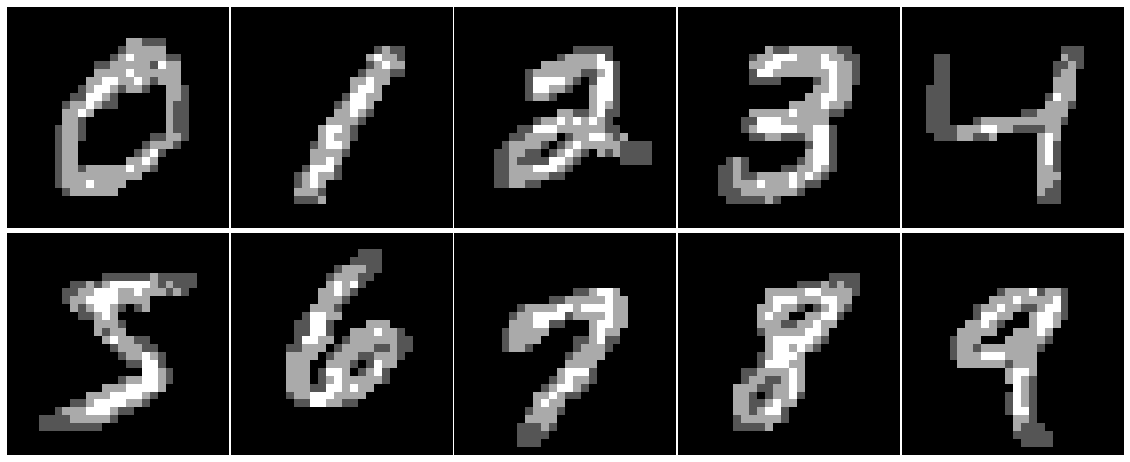

In [8]:
plotPanel(images,"img/sample{}X.png".format(ds))

In [15]:
saliencies=[]
for i in range(10):
    saliencies.append(np.loadtxt("train{}Y_score{}_log.txt".format(ds,i)).reshape((28,28)))

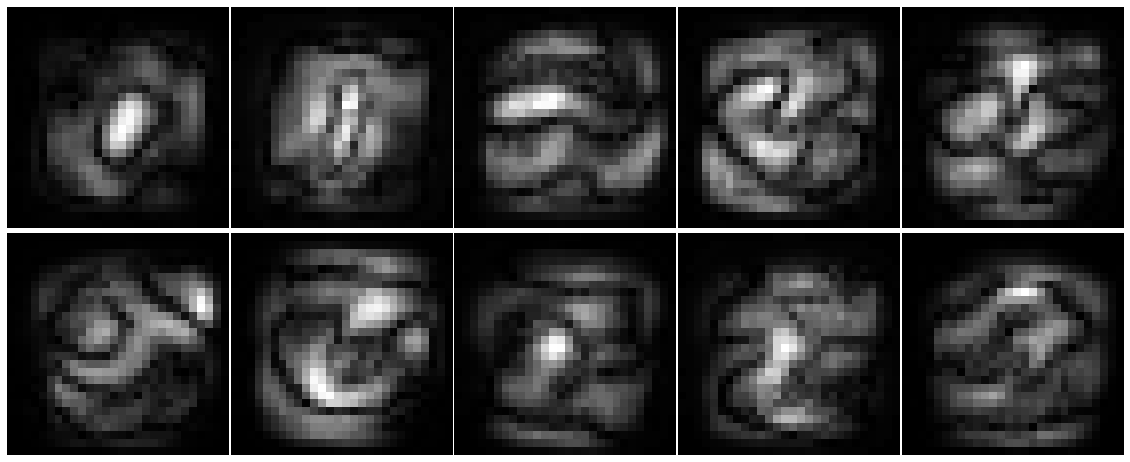

In [16]:
plotPanel(saliencies,"img/score1_{}X_log.png".format(ds))

In [17]:
saliencies=[]
for i in range(10):
    saliencies.append(np.loadtxt("train{}Y_score{}.txt".format(ds,i)).reshape((28,28)))

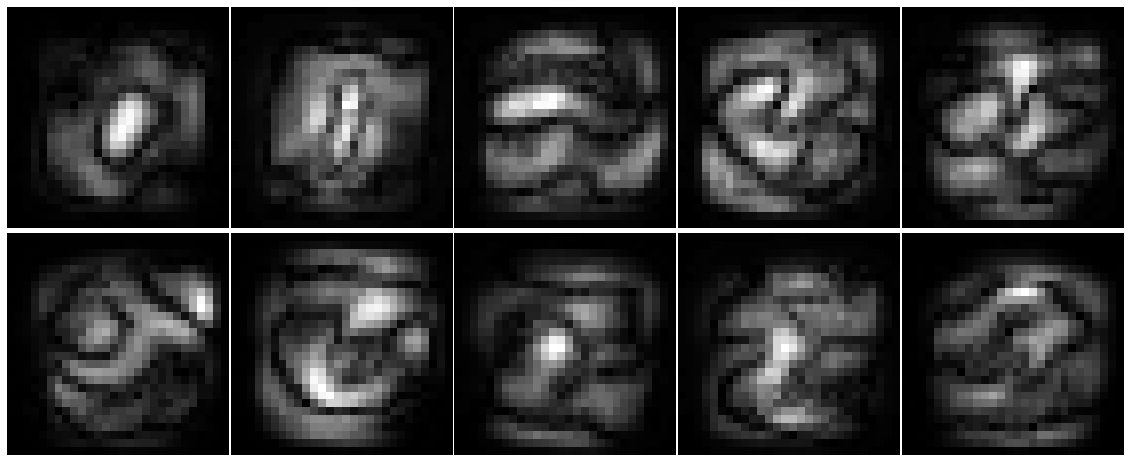

In [18]:
plotPanel(saliencies,"img/score1_{}X.png".format(ds))

In [28]:
from scipy.spatial.distance import squareform
saliencies2=[]
for i in range(10):
    try:
        saliencies2.append(squareform(np.loadtxt("train{}Y_score{}_2dim.txt".format(ds,i))))
    except:
        m=np.loadtxt("train{}Y_score{}_2dim.txt".format(ds,i))
        m+=m.T
        m/=2.
        m-=np.diag(np.diag(m))
        saliencies2.append(m)
saliencies2_eq=[exposure.equalize_adapthist(img, clip_limit=0.03) for img in saliencies2]

In [29]:
#saliencies2_eq=[squareform(img) for img in saliencies2_eq]

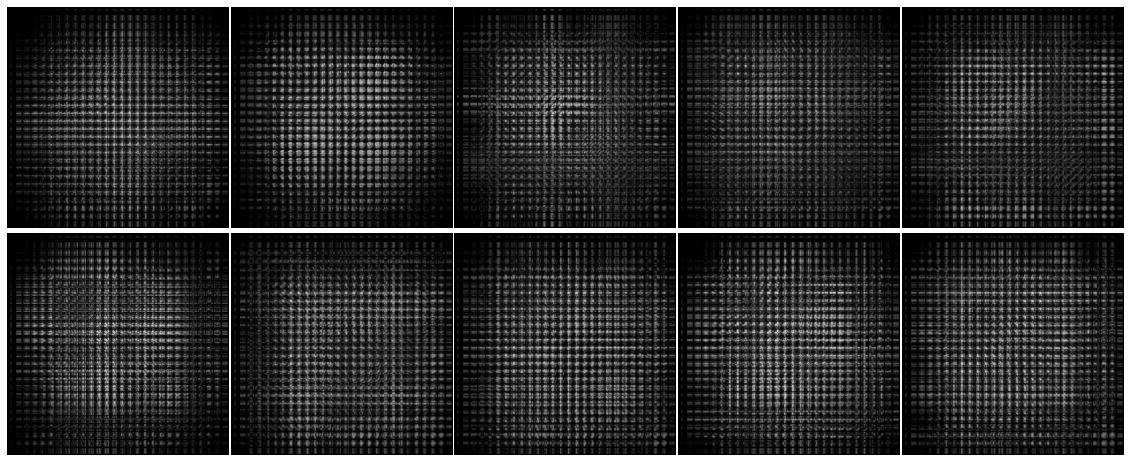

In [30]:
plotPanel(saliencies2_eq,"img/score2_{}X_2dim.png".format(ds),cmap='gray')

In [31]:
indexes2d=[]
for n in range(10):
    index=[]
    for v in np.sort(saliencies2[n].flatten())[-1000:]:
        index.extend(np.argwhere(saliencies2[n]==v))
    index=[tuple(sorted(list(idx))) for idx in index]
    index=list(set(index))
    index=[ (np.unravel_index(idx[0],shape=(28,28)),np.unravel_index(idx[1],shape=(28,28))) for idx in index ]
    index=[ idx for idx in index if np.linalg.norm(np.array(idx[0])-np.array(idx[1]))>4 ][:20]
    indexes2d.append(index)

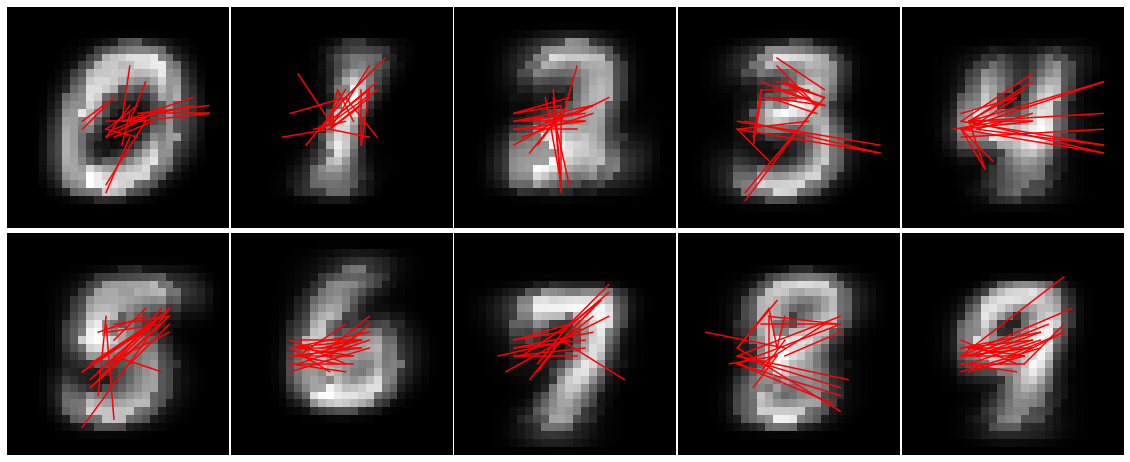

In [32]:
plotPanel(avg,"img/score2_{}X_2dimlines.png".format(ds),indexes=indexes2d)